<a href="https://colab.research.google.com/github/Dara4hem/Predictive-Analytics-for-Stock-Prices/blob/main/Predictive_Analytics_for_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and Import Libraries

In [ ]:
# Install necessary libraries
!pip install yfinance
!pip install tensorflow


In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


Data Collection

In [ ]:
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461977,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473150,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370184,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400682,447610800


Data Preprocessing

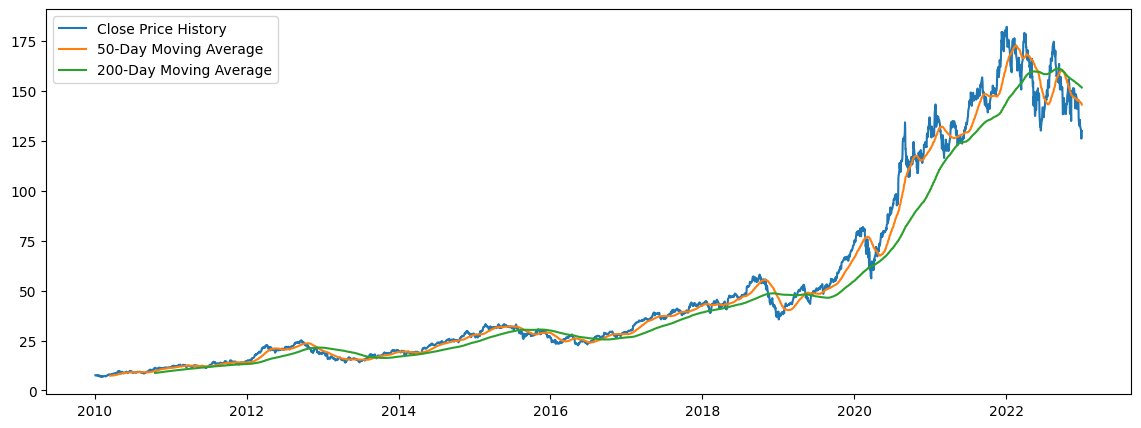

In [ ]:
# Handle missing values
data = data.dropna()

# Feature engineering: adding moving averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Data splitting
train_data = data[:'2020']
test_data = data['2021':]

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price History')
plt.plot(data['MA50'], label='50-Day Moving Average')
plt.plot(data['MA200'], label='200-Day Moving Average')
plt.legend()
plt.show()


 Model Development

In [ ]:
# Data scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

# Creating training dataset
X_train, y_train = [], []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0123
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 2.6230e-04
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 2.6417e-04
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 2.3020e-04
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.3387e-04
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.8828e-04
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 2.2778e-04
Epoch 8/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.3512e-04
Epoch 9/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 1.8169e-04
Epoch 10/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 1.6876e-04
Epoch 11/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 1.7692e-04
Epoch 12/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1.4141e-04
Epoch 13/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 1.4584e-04
Epoch 14/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.4953e-04
Epoch 15/25
85/85 ━━━━━━━━━━

Model Evaluation


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


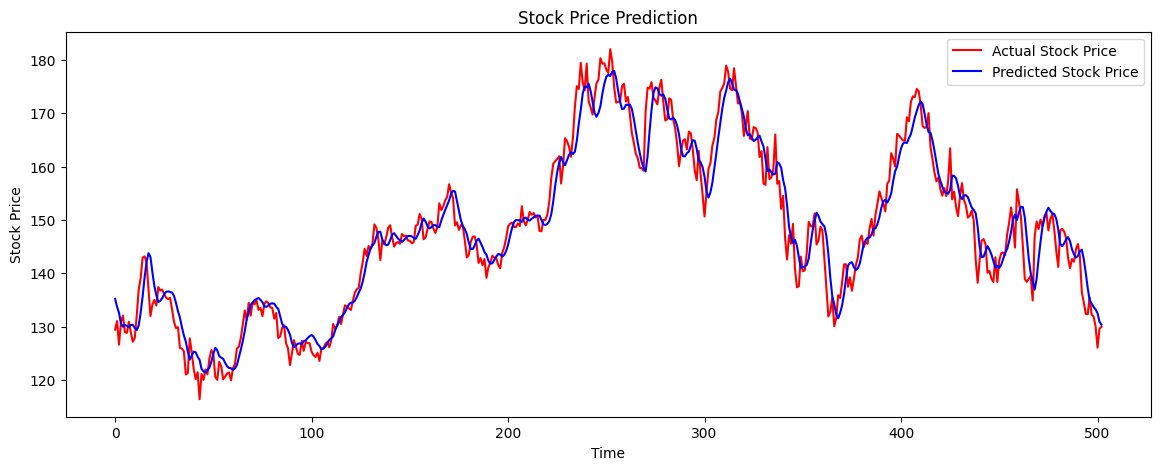

In [ ]:
# Preparing test data
test_data_total = pd.concat((train_data['Close'], test_data['Close']), axis=0)
inputs = test_data_total[len(test_data_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(test_data['Close'].values, color='red', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
